# Implementing and comparing LRP techniques
This notebook loads MNIST data (60 000 images), builds and trains a simple MLP with layer sizes 784x300x100x10, and implements Layer-wise Relevance Propagation to construct a heatmap of the input pixels which supposedly have the most impact on the output.

In [2]:
import torch
from torch import nn

from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

import numpy as np

## 0. Load datset

In [3]:
# Load dataset

train = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

Image shape: torch.Size([1, 28, 28])


Text(0.5, 1.0, '5')

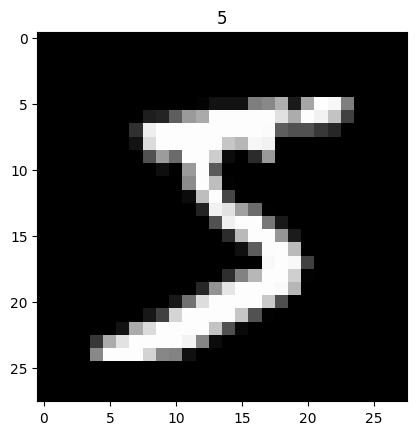

In [4]:
image, label = train[0]
print(f"Image shape: {image.shape}")
plt.imshow(image.squeeze(), cmap="gray")
plt.title(label)

In [5]:
BATCH_SIZE = 32

train_dataloader = DataLoader(
    train,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader = DataLoader(
    test,
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [6]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

## 1. Train simple model

In [7]:
device = torch.device('mps')

In [8]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    return correct / len(y_pred) * 100

In [9]:
def train_model(model, optimizer, loss_fn):
    torch.manual_seed(42)
    epochs = 1#3

    for epoch in range(epochs):
        print(f"[EPOCH {epoch+1}/{epochs}] ", end="")
        train_loss = 0

        for batch, (X, y) in enumerate(train_dataloader):
            X, y = X.to(device), y.to(device)
            model.train()

            y_pred = model(X)

            loss = loss_fn(y_pred, y)
            train_loss += loss

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

        train_loss /= len(train_dataloader)

        test_loss, test_acc = 0, 0
        model.eval()
        with torch.inference_mode():
            for X, y in test_dataloader:
                X, y = X.to(device), y.to(device)
                test_pred = model(X)

                test_loss += loss_fn(test_pred, y)
                test_acc += accuracy_fn(y, test_pred.argmax (dim=1))

            test_loss /= len(test_dataloader)
            test_acc /= len(test_dataloader)

        print(f"Train loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

In [10]:
# Build the model
inputs = 784
hidden1 = 300
hidden2 = 100
outputs = 10

assert(outputs == len(train.classes))

model = nn.Sequential(
    nn.Flatten(),
    nn.ReLU(),
    nn.Linear(inputs, hidden1),
    nn.ReLU(),
    nn.Linear(hidden1, hidden2),
    nn.ReLU(),
    nn.Linear(hidden2, outputs)
).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

In [11]:
train_model(model, optimizer, loss_fn)

[EPOCH 1/1] Train loss: 0.35210 | Test loss: 0.14583, Test acc: 95.51%


## 2. Attacks
### 2.0 Boilerplate

In [13]:
from tqdm import tqdm

In [45]:
def evaluate_attack(subset, kernel_size, step, annotate_image):
    kx_range = range(0, 28, step)
    ky_range = range(0, 28, step)

    accuracies = [np.zeros((len(kx_range), len(ky_range))) for _ in range(10)]
    losses = [np.zeros((len(kx_range), len(ky_range))) for _ in range(10)]

    for digit in tqdm(range(10)):
        for i, kx in enumerate(kx_range):
            for j, ky in enumerate(ky_range):
                attack = datasets.MNIST(
                    root="data",
                    train=False,
                    download=True,
                    transform=Lambda(
                        lambda x: annotate_image(kx, ky, kernel_size, ToTensor()(x).squeeze())
                    ),
                )
                attack = torch.utils.data.Subset(attack, range(subset))

                #image, _ = attack[0]
                #plt.imshow(image.squeeze(), cmap="gray")
                #plt.title(label)
                #plt.show()

                attack_loader = DataLoader(
                    torch.utils.data.Subset(attack, [i for i, (_, y) in enumerate(attack) if y == digit]),
                    batch_size=BATCH_SIZE,
                    shuffle=False
                )

                test_loss, test_acc = 0, 0
                model.eval()
                with torch.inference_mode():
                    for X, y in attack_loader:
                        X, y = X.to(device), y.to(device)
                        test_pred = model(X)

                        test_loss += loss_fn(test_pred, y)
                        test_acc += accuracy_fn(y, test_pred.argmax (dim=1))

                    if len(attack_loader) != 0:
                        test_loss /= len(attack_loader)
                        test_acc /= len(attack_loader)

                accuracies[digit][j][i] = test_acc
                losses[digit][j][i] = test_loss

    return accuracies, losses

In [52]:
def visualize_accuracies(accuracies):
    fig, axs = plt.subplots(2, 5, figsize=(15,7))

    for digit in range(10):
        image, _ = torch.utils.data.Subset(train, [i for i, (_, y) in enumerate(train) if y == digit])[0]
        image = torch.flip(image, [0, 1]) # idk why I need to flip it but alright
        
        axs[digit//5][digit%5].imshow(accuracies[digit])
        axs[digit//5][digit%5].contour(image.squeeze(), levels=[0.1], colors='red', origin='image')
        axs[digit//5][digit%5].set_title(f"Accuracies per attack zone\n Digit = {digit}")
    plt.show()

    plt.imshow(np.mean(np.array(accuracies), axis=0))
    plt.colorbar()
    plt.title("Accuracies per attack zone\n All classes average")
    plt.plot()

### 2.1 Invert attack
Attacked pixels receive the following transformation:
$$x\longleftarrow 1-x$$

In [55]:
SUBSET = 1000
KERNEL_SIZE = 4
STEP = 1

def invert_attack(kx, ky, kernel_size, image):
    #image[ky:ky+kernel_size, kx:kx+kernel_size] = torch.rand(image[ky:ky+kernel_size, kx:kx+kernel_size].shape)
    image[ky:ky+kernel_size, kx:kx+kernel_size] = 1 - image[ky:ky+kernel_size, kx:kx+kernel_size]
    return image

accuracies, losses = evaluate_attack(SUBSET, KERNEL_SIZE, STEP, invert_attack)

100%|██████████| 10/10 [06:17<00:00, 37.71s/it]


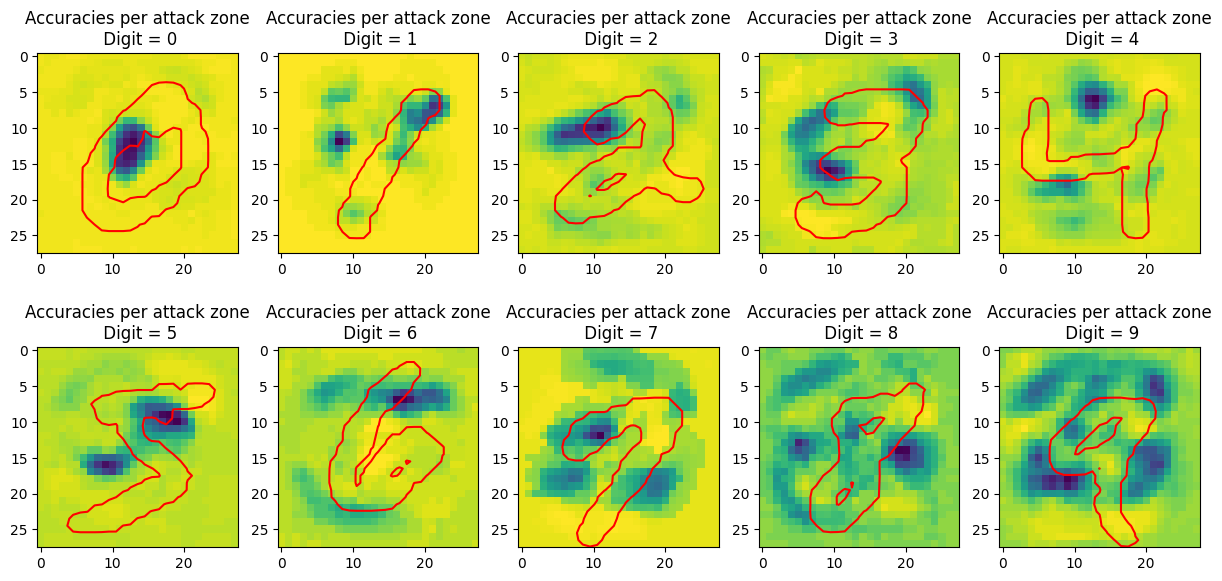

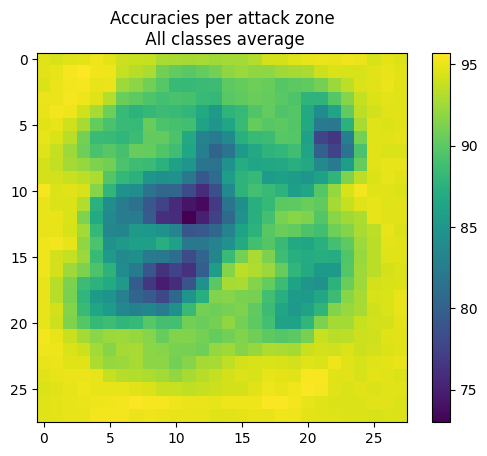

In [58]:
visualize_accuracies(accuracies)

### 2.2 Random attack
Attacked pixels receive the following transformation:
$$x\longleftarrow \mathcal{U}([0, 1[)$$

In [56]:
SUBSET = 1000
KERNEL_SIZE = 4
STEP = 1

def random_attack(kx, ky, kernel_size, image):
    image[ky:ky+kernel_size, kx:kx+kernel_size] = torch.rand(image[ky:ky+kernel_size, kx:kx+kernel_size].shape)
    return image

accuracies, losses = evaluate_attack(SUBSET, KERNEL_SIZE, STEP, invert_attack)

100%|██████████| 10/10 [06:15<00:00, 37.56s/it]


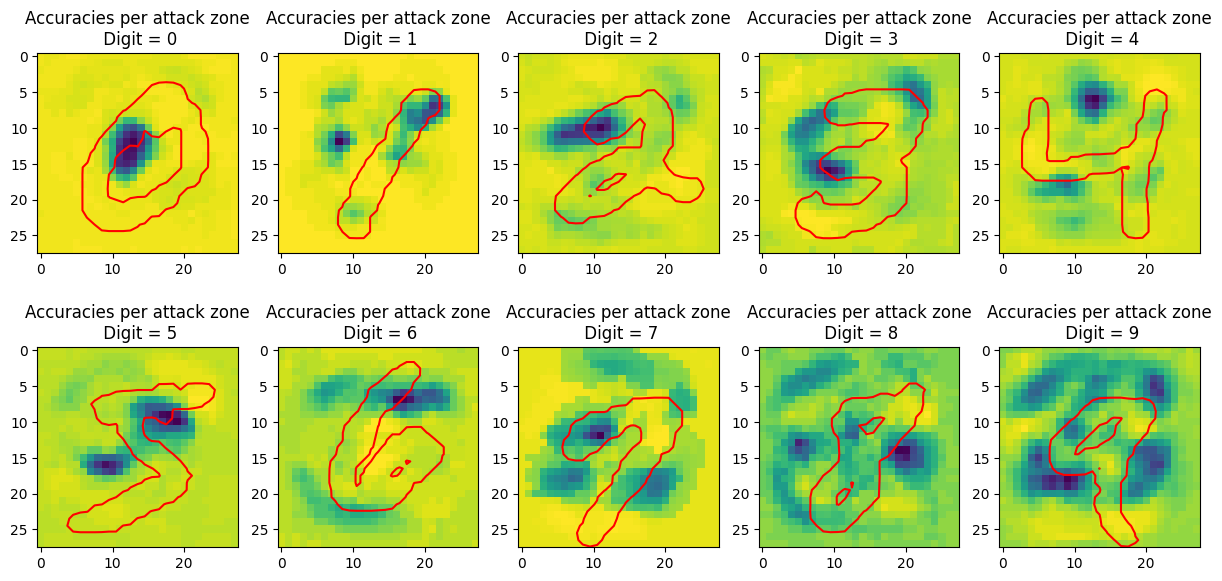

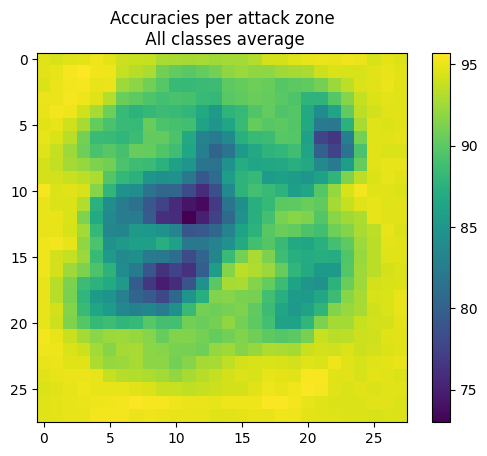

In [57]:
visualize_accuracies(accuracies)